In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import softmax
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

import torch.optim as optim
import torch.nn as nn

# Log
from torch.utils.tensorboard import SummaryWriter

from IPython import display

import sqlite3
import time
import math
from copy import deepcopy
import os
import datetime
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from models.TrajectoryDataset import TrajectoryPredictionDataset

from models.indivSeq2Seq_residual import IndividualTF

In [2]:
dataset_name = "eth" # dataset options: 'university', 'zara_01', 'zara_02', 'eth', 'hotel'

#Building of output folder
now = datetime.datetime.now() # current date and time
__file__=os.getcwd()
current_time_date = now.strftime("%d_%m_%y_%H_%M_%S")
run_folder  = "Outputs/traj_pred_"+ dataset_name + "_" + str(os.path.basename(__file__)) + str(current_time_date)
os.makedirs(run_folder)

# Make log folder for tensorboard
#SummaryWriter_path = run_folder + "/log"
#os.makedirs(SummaryWriter_path) 
SummaryWriter_path = '/notebook_data/work_dirs/first_test'
writer = SummaryWriter(SummaryWriter_path,comment="ADE_FDE_Train")

# Make image folder to save outputs
image_path  = run_folder + "/Visual_Prediction"
os.makedirs(image_path)

#cuda env
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.cuda.device_count()
    torch.cuda.current_device()
else :
    device = torch.device("cpu")

In [3]:
#DataBase Variables
image_folder_path       = 'data/data_trajpred/'+dataset_name
DB_PATH_train     = "./data/data_trajpred/"+dataset_name+"/pos_data_train.db"
cnx_train         = sqlite3.connect(DB_PATH_train)
DB_PATH_val     = "./data/data_trajpred/"+dataset_name+"/pos_data_val.db"
cnx_val         = sqlite3.connect(DB_PATH_val)
DB_DIR      = run_folder + '/database'
os.makedirs( DB_DIR )
DB_PATH2    = DB_DIR+'/db_one_ped_delta_coordinates_results.db'
cnx2        = sqlite3.connect(DB_PATH2)

In [4]:
#Other variables
T_obs                   = 8
T_pred                  = 12
T_total                 = T_obs + T_pred #8+12=20
data_id                 = 0 
batch_size              = 32 #10#100 #15 #2
chunk_size              = batch_size * T_total # Chunksize should be multiple of T_total
in_size                 = 2
stochastic_out_size     = in_size * 2
hidden_size             = 256 #!64
embed_size              = 64 #16 #!64
global dropout_val
dropout_val             = 0.2 #0.5
teacher_forcing_ratio   = 0.7 # 0.9
regularization_factor   = 0.5 # 0.001
avg_n_path_eval         = 20
bst_n_path_eval         = 20
path_mode               = "top5" #"avg","bst","single","top5"
regularization_mode     = "regular" #"weighted","e_weighted", "regular"
startpoint_mode         = "on" #"on","off"
enc_out                 = "on" #"on","off"
biased_loss_mode        = 0 # 0 , 1

table_out   = "results_delta"
table       = "dataset_T_length_20delta_coordinates" #"dataset_T_length_"+str(T_total)+"delta_coordinates"
df_id       = pd.read_sql_query("SELECT data_id FROM "+table, cnx_train)
data_size   = df_id.data_id.max() * T_total
epoch_num   = 500
from_epoch  = 0

#Visual Variables
image_size              = 256  
image_dimension         = 3
mask_size               = 16
visual_features_size    = 128 
visual_embed_size       = 64  #128 #256 #64
vsn_module_out_size    = 256
to_pil = torchvision.transforms.ToPILImage()


#Model Path
model_path = run_folder + "/NNmodel"
os.makedirs(model_path)   
model_path = model_path + str("/model")

In [5]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.2, 0.2)

        
def distance_from_line_regularizer(input_tensor, prediction):
    sum_sigma_distance = torch.zeros(1)
    input_tensor = input_tensor.double()
    prediction = prediction.double()
    input_tensor = input_tensor.cumsum(dim=1)
    X = torch.ones_like(input_tensor).to('cuda', non_blocking=True)
    X[:,:,0] = input_tensor[:,:,0]
    Y = (input_tensor[:,:,1]).unsqueeze(-1)
    try:
        try:
            XTX_1 = torch.matmul(X.transpose(-1,-2), X).inverse()
        except:
            XTX_1 = torch.matmul(X.transpose(-1,-2), X).ppinverse()
        XTY = torch.matmul( X.transpose(-1,-2), Y)
        theta = torch.matmul( XTX_1.double(), XTY)
        
        # Calculate real values of prediction instead of delta
        prediction[:,:,0] = prediction[:,:,0] + input_tensor[:,-1,0].unsqueeze(-1) 
        prediction[:,:,1] = prediction[:,:,1] + input_tensor[:,-1,1].unsqueeze(-1)
        
        # Calculate distance ( predicted_points , observation_fitted_line ) over batch
        theta0x0        = theta[:,0,:] * prediction[:,:,0]
        denominator     = torch.sqrt( theta[:,0,:] * theta[:,0,:] + 1 )
        nominator       = theta0x0 + theta[:,1,:] - prediction[:,:,1]
        distance        = nominator.abs() / denominator
        if regularization_mode =='weighted':
            weight              = torch.flip( torch.arange(1,T_pred+1).cuda().double(),[0])
            weight              = (weight / T_pred).repeat(distance.size(0)).view(-1,T_pred)
            weighted_distance   = weight * distance

        elif regularization_mode =='e_weighted':
            weight              = torch.flip( torch.arange(1,T_pred+1).cuda().double(),[0])
            weight              = (weight / T_pred).repeat(distance.size(0)).view(distance.size(0),T_pred)
            weight              = torch.exp(weight)
            weighted_distance   = weight*distance

        else:
            weighted_distance = distance
        sigma_distance  = torch.mean(weighted_distance,1)
        sum_sigma_distance  = torch.mean(sigma_distance)
        return sum_sigma_distance
    except:
        print("SINGULAR VALUE")
        sum_sigma_distance = torch.zeros(1).to('cuda', non_blocking=True) + 20
        return sum_sigma_distance

## Training

In [6]:
#train dataset and loader

batch_size = 32
print("Initializing train dataset")
print("Batch_size : {}".format(batch_size))
dataset_train = TrajectoryPredictionDataset(image_folder_path, cnx_train)
train_loader  = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)
validation_loader = None

Initializing train dataset
Batch_size : 32


In [7]:
model = IndividualTF(device,2,2,2,6,512,2048,dropout=dropout_val)
model = model.to(device).double()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
learning_step               = 40
initial_learning_rate       = 0.01
clip                        = 1

# MSE loss
criterion                   = nn.MSELoss(reduction='mean')
criterion_vision            = nn.MSELoss(reduction='sum')

# SGD optimizer
optimizer                   = optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.01) #SGD
scheduler                   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_step, gamma=0.1)
five_fold_cross_validation  = 0

In [9]:
def save_checkpoint(state, is_best, save_path, filename):
    torch.save(state, os.path.join(save_path,filename))
    if is_best:
        shutil.copyfile(os.path.join(save_path,filename), os.path.join(save_path,'model_best.pth'))
        
def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0
        
def train(model, optimizer, scheduler, criterion, criterion_vision, clip,train_loader, validation_loader, save_path=None):
    global batch_size
    i               = None
    checked_frame   = 0

    losses = []
    print("Data Size ",data_size,"\tChunk Size ",chunk_size)
    global teacher_forcing_ratio
    counter =0
    best_val = float("inf")
    for j in range(epoch_num):
        model.train()
        epoch_loss=0
        if j%7 == 6:
            teacher_forcing_ratio = (teacher_forcing_ratio - 0.2) if teacher_forcing_ratio>=0.1 else 0.0

        # Update TeachForce ratio to gradually change during training
        # global teacher_forcing_ratio
        # teacher_forcing_ratio-= 1/epoch_num
        print("TEACHER FORCE RATIO\t",teacher_forcing_ratio)
        #print("Learning Rate\t", scheduler.get_last_lr())

        
        if(j>=from_epoch):
            optimizer.zero_grad()
            start_time = time.time()
            ADE = 0
            FDE = 0
            i   = 0
            for i,data in enumerate(train_loader):
                #print("\n--------------- Batch %d/ %d ---------------"%(j,i)) #(epoch/i)
                # Forward
                obs, pred, visual_obs, frame_tensor = data
                
                input_tensor, output_tensor         = obs.double().squeeze(dim=1).to('cuda', non_blocking=True), pred.double().squeeze(dim=1).to('cuda', non_blocking=True)
                    
                visual_input_tensor                 = visual_obs.double().squeeze(dim=1).to('cuda', non_blocking=True)
                
                src_att = torch.ones((input_tensor.shape[0], 1, input_tensor.shape[1])).to(device)
                trg_att=subsequent_mask(output_tensor.shape[1]).repeat(output_tensor.shape[0],1,1).to(device)
                
                prediction = model(input_tensor, output_tensor, visual_input_tensor, src_att, trg_att)
                
                calculated_prediction = prediction.cumsum(axis=1) #calculated_prediction
                
                loss_line_regularizer = distance_from_line_regularizer(input_tensor,calculated_prediction) #loss (regularisation term Lreg)
                
                if biased_loss_mode:
                    weight  = torch.arange(1,2*T_pred+1,2).cuda().float()
                    weight  = torch.exp(weight / T_pred).repeat(prediction.size(0)).view(prediction.size(0),T_pred,1)
                    loss    = criterion( (calculated_prediction)*weight, torch.cumsum(output_tensor,dim=-2)*weight)
                else:
                    loss    = criterion( (calculated_prediction), torch.cumsum(output_tensor,dim=-2)) #mean squared error (lmse)
                    
                out_x       = output_tensor[:,:,0].cumsum(axis=1)
                out_y       = output_tensor[:,:,1].cumsum(axis=1)
                pred_x      = calculated_prediction[:,:,0]
                pred_y      = calculated_prediction[:,:,1]
                ADE         += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0).mean(0)   
                # FDE      += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0)[-1]
                
                # Backward Propagation
                total_loss      = loss.double() + torch.tensor(regularization_factor).to('cuda', non_blocking=True) * loss_line_regularizer.double() #total loss
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                #print("Total Loss\t{:.2f}".format(total_loss.item()))
                epoch_loss += total_loss.item()
                #print("Time\t\t{:.2f} sec \n".format(time.time() - start_time))
                start_time = time.time()
                torch.cuda.empty_cache()
                writer.close()
                count_div=i
            
            # tensorboard log
            writer.add_scalar('ADE/train', ADE.item()/(count_div+1), counter)
            # writer.add_scalar('FDE/train', FDE.item()/(count_div+1), counter)
            # writer.add_scalar('LOSS/train', epoch_loss/(count_div+1), counter)
            counter += 1

        if scheduler.get_last_lr()[0]>0.001:
            scheduler.step()
        # validation(model, optimizer, criterion, criterion_vision, clip, validation_loader, j) 
        epoch_loss = epoch_loss / (int(data_size/chunk_size))
        losses.append(epoch_loss)
        display.clear_output(wait=True)
        plt.plot(losses, '--ro', label='train loss')
        plt.legend()
        plt.title(f'epoch {j}')
        plt.show()
        print("Time\t\t{:.2f} sec \n".format(time.time() - start_time))
        print("EPOCH ", j, "\tLOSS ", epoch_loss)
        writer.add_scalar('epoch_loss/train', epoch_loss/ (int(data_size/chunk_size)), j ) #see how model performs on the training dataset
        #torch.save( model.state_dict(), model_path+"_current")
        print("-----------------------------------------------\n"+"-----------------------------------------------")

        # save checkpoint for each epoch and a fine called best_model so far 
        print(np.argmin(losses))
        is_best = epoch_loss < best_val
        best_val = min(epoch_loss, best_val)
        print("bestvaleur", best_val)
        if save_path and (j+1)%5==0:
            save_checkpoint({'epoch': j+1,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'scheduler': scheduler.state_dict(),'best_loss': best_val}, is_best, save_path, 'epoch_{}.pth'.format(j+1))
        
    return epoch_loss / (int(data_size/chunk_size))

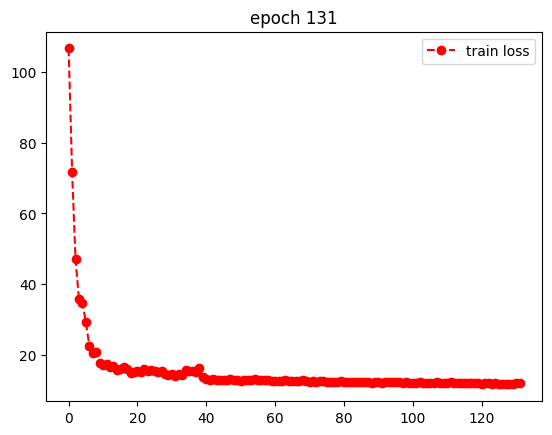

Time		0.41 sec 

EPOCH  131 	LOSS  11.848689018663539
-----------------------------------------------
-----------------------------------------------
123
bestvaleur 11.547311310828873
TEACHER FORCE RATIO	 0.0


KeyboardInterrupt: 

In [10]:
print("TRAIN")
model.train()
print("path mode\t",path_mode)

save_path = "./save_models/bimodal_transfo/"
loss  = train(model, optimizer, scheduler, criterion, criterion_vision, clip, train_loader, validation_loader, save_path)
print("LOSS ",loss)